# Import Libraries

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
pd.options.mode.chained_assignment = None
%matplotlib inline

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/stroke-prediction-dataset/healthcare-dataset-stroke-data.csv


# Data Analysis

In [2]:
df = pd.read_csv("../input/stroke-prediction-dataset/healthcare-dataset-stroke-data.csv")

To predict the stroke, we have 3 continuous variables - *age, avg_glucose_level, bmi* and 7 categorical variables - *gender,hypertension, heart_disease, ever_married, Work_type, residence_type, smoking_status*. *id* is just a unique number without any value towards stroke prediction and can be dropped 

In [3]:
df.describe(include='all')

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
count,5110.000000,5110,5110.000000,5110.000000,5110.000000,5110,5110,5110,5110.000000,4909.000000,5110,5110.000000
unique,NaN,3,NaN,NaN,NaN,2,5,2,NaN,NaN,4,NaN
top,NaN,Female,NaN,NaN,NaN,Yes,Private,Urban,NaN,NaN,never smoked,NaN
freq,NaN,2994,NaN,NaN,NaN,3353,2925,2596,NaN,NaN,1892,NaN
mean,36517.829354,NaN,43.226614,0.097456,0.054012,NaN,NaN,NaN,106.147677,28.893237,NaN,0.048728
std,21161.721625,NaN,22.612647,0.296607,0.226063,NaN,NaN,NaN,45.283560,7.854067,NaN,0.215320
min,67.000000,NaN,0.080000,0.000000,0.000000,NaN,NaN,NaN,55.120000,10.300000,NaN,0.000000
25%,17741.250000,NaN,25.000000,0.000000,0.000000,NaN,NaN,NaN,77.245000,23.500000,NaN,0.000000
50%,36932.000000,NaN,45.000000,0.000000,0.000000,NaN,NaN,NaN,91.885000,28.100000,NaN,0.000000
75%,54682.000000,NaN,61.000000,0.000000,0.000000,NaN,NaN,NaN,114.090000,33.100000,NaN,0.000000


based on the above
1. *bmi* holds a few null values
2. *bmi* ranges from 10 to 97. [We know that, bmi <18.5 is underweight, 18.5 - 25 healthy, 25 - 30 overweight, >30 Obese, >50 morbidly obese (very rare and almost impossible)]. Hence, very high bmi values can be considered as noise/outliers.


In [4]:
df_no_mv = df.dropna(axis=0, how='any')
df_opt_bmi = df_no_mv[df_no_mv['bmi']<=50]

#dropping id
data = df_opt_bmi.drop(['id'], axis =1).reset_index(drop=True)

Number of people without stroke attack -  4622
Number of people with stroke attack -  208


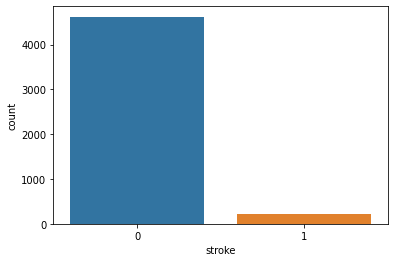

In [5]:
y = data.stroke
x = data.drop(['stroke'], axis=1)
ax = sns.countplot(x=y, label = 'stroke count')
N , Y = y.value_counts()
print('Number of people without stroke attack - ', N)
print('Number of people with stroke attack - ', Y)

In [6]:
# Splitting the inputs into continuous and categorical variables
x_cont = x[['age','avg_glucose_level','bmi']]
x_cat = x.drop(['age','avg_glucose_level','bmi'], axis =1)

# Analyzing continuous variables

<AxesSubplot:xlabel='avg_glucose_level', ylabel='value'>

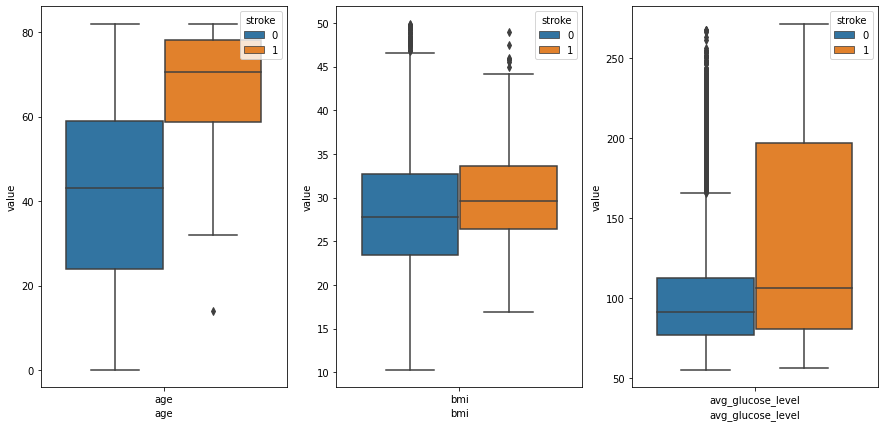

In [7]:
#Understanding continuous variables using a box plot

f, axes = plt.subplots(1,3, figsize=(15,7))

data_age = pd.concat([y, x_cont['age']], axis=1)
data_plot_age = pd.melt(data_age, id_vars = 'stroke', var_name = 'age')
sns.boxplot(x='age', y='value', hue='stroke', data=data_plot_age,ax=axes[0])

data_bmi = pd.concat([y, x_cont['bmi']], axis=1)
data_plot_bmi = pd.melt(data_bmi, id_vars = 'stroke', var_name = 'bmi')
sns.boxplot(x='bmi', y='value', hue='stroke', data=data_plot_bmi,ax=axes[1])

data_agl = pd.concat([y, x_cont['avg_glucose_level']], axis=1)
data_plot_agl = pd.melt(data_agl, id_vars = 'stroke', var_name = 'avg_glucose_level')
sns.boxplot(x='avg_glucose_level', y='value', hue='stroke', data=data_plot_agl,ax=axes[2])

From the plot above, we see that, there is a clear distinction in age, indicating that old people are more prone to stroke. The BMI attribute has a few outliers in the upper end and has most values overlapping in the middle quartile.

Interestingly, the box plot of avg_glucose_level displays multiple datapoints as outliers, mandating the need for further analysis

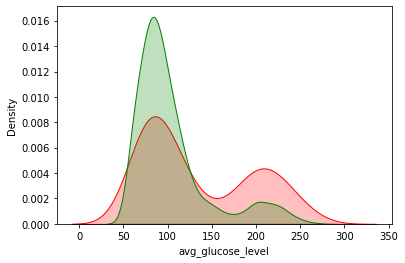

In [8]:
#Analysing avg_glucose_level attribute

stroke1 =data_agl[data_agl['stroke']==1]
stroke0 =data_agl[data_agl['stroke']==0]

sns.kdeplot(stroke1['avg_glucose_level'], shade=True, color="r")
sns.kdeplot(stroke0['avg_glucose_level'], shade=True, color="g")

plt.show()

Green and red denotes those without stroke and with stroke respectively.

Thus, the anomaly observed in box plot is justified by the bimodal distribution of data. 

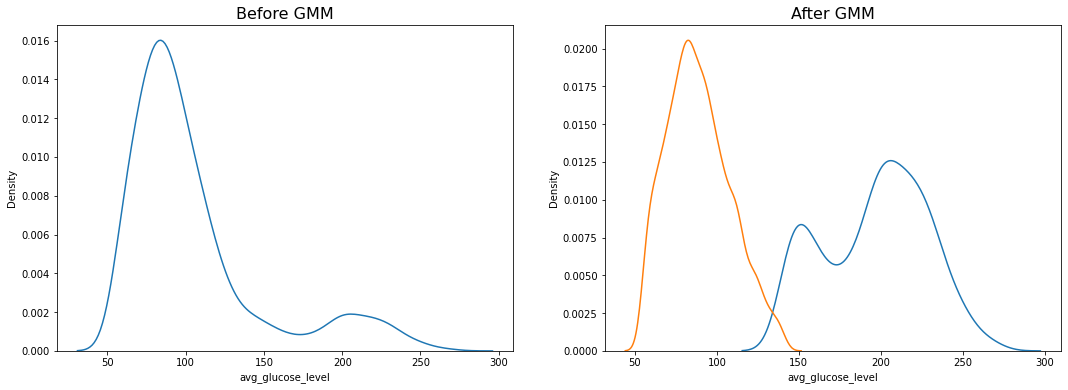

In [9]:
# Using Gausian Mixture Model(GMM)

from sklearn.mixture import GaussianMixture

gmm = GaussianMixture(n_components=2, random_state=42)
gmm.fit(data_agl['avg_glucose_level'].values.reshape(-1, 1))
data_agl['gmm']= gmm.predict(data_agl['avg_glucose_level'].values.reshape(-1, 1))

#Visualization
f, ax = plt.subplots(1,2, figsize=(18, 6))
sns.kdeplot(data=data_agl['avg_glucose_level'], ax=ax[0])
ax[0].set_title('Before GMM', fontsize=16)
sns.kdeplot(data=data_agl[data_agl['gmm']==0].avg_glucose_level, label='Component 1', ax=ax[1])
sns.kdeplot(data=data_agl[data_agl['gmm']==1].avg_glucose_level, label='Component 2', ax=ax[1])
ax[1].set_title('After GMM', fontsize=16)
plt.show()

# Adding gmm to the input dataset
x['gmm'] = data_agl['gmm']


GMM model helps in identifying and splitting the subpopulations in a normally distributed data. In this case, we are taking datapoints with low average_glucose_level as 0 and the higher value as 1. Since, the healthy population has agl < 140, it understandable that maximum datapoints fall in 0.

# Analyzing categorical variables

<AxesSubplot:xlabel='Residence_type', ylabel='0'>

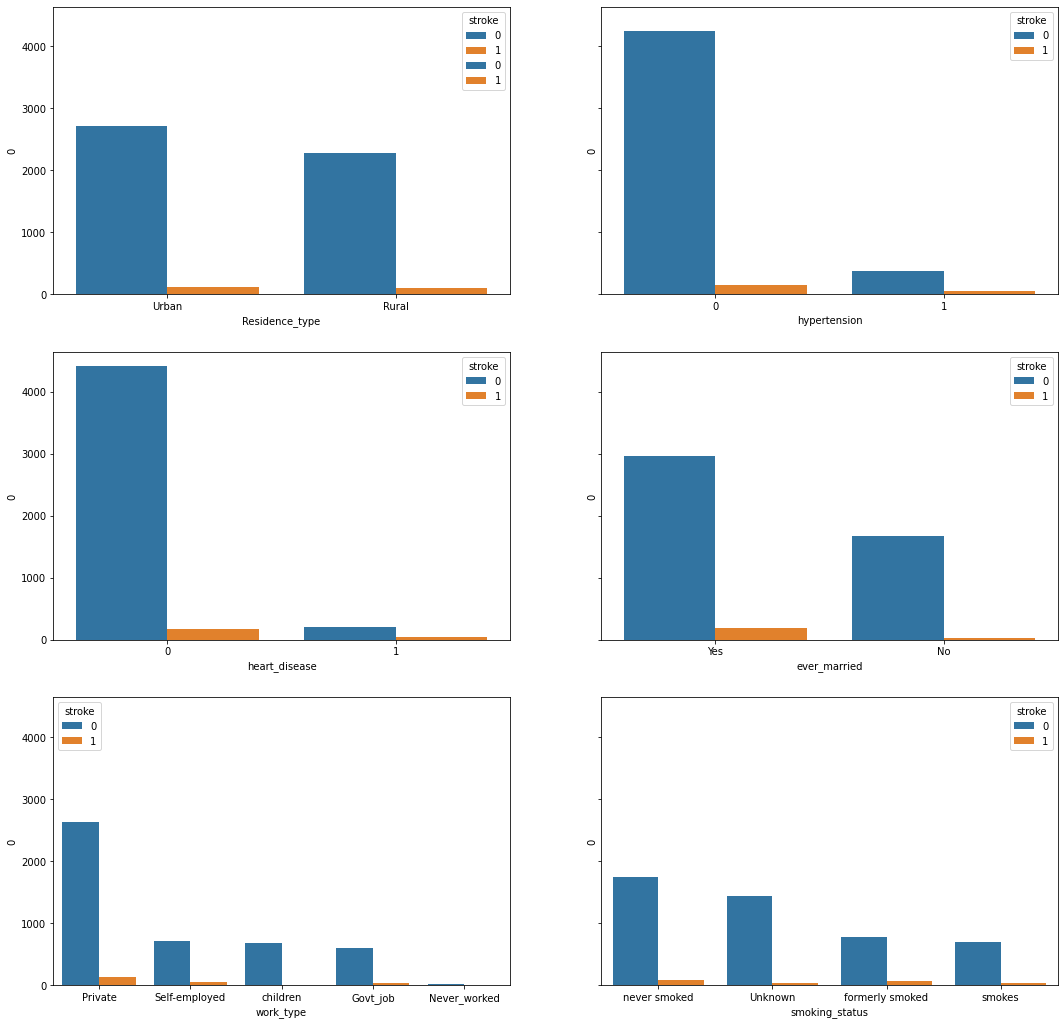

In [10]:
# Using bar plot to understand categorical variables

f, axes = plt.subplots(3, 2, sharey = True, figsize =(18,18))
data_cat = pd.concat([y, x_cat], axis=1)
                          
#gender
data_g = data_cat[['stroke','gender']].value_counts().reset_index()
sns.barplot(x="gender", y=0, hue="stroke", data=data_g, ax=axes[0, 0])
       
#hypertension
data_h = data_cat[['stroke','hypertension']].value_counts().reset_index()
sns.barplot(x="hypertension", y=0, hue="stroke", data=data_h,ax=axes[0, 1])
                          
#heart_disease
data_hd = data_cat[['stroke','heart_disease']].value_counts().reset_index()
sns.barplot(x="heart_disease", y=0, hue="stroke", data=data_hd, ax=axes[1, 0])

#ever_married
data_em = data_cat[['stroke','ever_married']].value_counts().reset_index()
sns.barplot(x="ever_married", y=0, hue="stroke", data=data_em, ax=axes[1, 1])
       
#work_type
data_wt = data_cat[['stroke','work_type']].value_counts().reset_index()
sns.barplot(x="work_type", y=0, hue="stroke", data=data_wt,ax=axes[2, 0])
                          
#smoking_status
data_ss = data_cat[['stroke','smoking_status']].value_counts().reset_index()
sns.barplot(x="smoking_status", y=0, hue="stroke", data=data_ss, ax=axes[2, 1])

#residence_type
data_rt = data_cat[['stroke','Residence_type']].value_counts().reset_index()
sns.barplot(x="Residence_type", y=0, hue="stroke", data=data_rt, ax=axes[0, 0])

In [11]:
#Encoding categarical variables
from sklearn.preprocessing import LabelEncoder

labelEncoder = LabelEncoder()
x_cat_pp = pd.DataFrame()
x_cat_pp['gender'] = labelEncoder.fit_transform(x_cat['gender'])
x_cat_pp["ever_married"] = labelEncoder.fit_transform(x_cat['ever_married'])
x_cat_pp['work_type'] = labelEncoder.fit_transform(x_cat['work_type'])
x_cat_pp['Residence_type'] = labelEncoder.fit_transform(x_cat['Residence_type'])
x_cat_pp['smoking_status'] = labelEncoder.fit_transform(x_cat['smoking_status'])
x_cat_pp['heart_disease'] = labelEncoder.fit_transform(x_cat['heart_disease'])
x_cat_pp['hypertension'] = labelEncoder.fit_transform(x_cat['hypertension'])

In [12]:
x_cat_pp

,gender,ever_married,work_type,Residence_type,smoking_status,heart_disease,hypertension
0,1,1,2,1,1,1,0
1,1,1,2,0,2,1,0
2,0,1,2,1,3,0,0
3,0,1,3,0,2,0,1
4,1,1,2,1,1,0,0
...,...,...,...,...,...,...,...
4825,0,0,4,0,0,0,0
4826,0,1,3,1,2,0,0
4827,0,1,3,0,2,0,0
4828,1,1,2,0,1,0,0


# Collinearity

In [13]:
x_pp = pd.concat([x_cont, x_cat_pp, x['gmm']], axis=1)

#Dropping avg_glucose_level, since gmm attribute gives a better understanding of avg_glucose_level
x_pp = x_pp.drop(['avg_glucose_level'], axis=1)

x_pp.describe()


,age,bmi,gender,ever_married,work_type,Residence_type,smoking_status,heart_disease,hypertension,gmm
count,4830.000000,4830.000000,4830.000000,4830.000000,4830.000000,4830.000000,4830.000000,4830.000000,4830.000000,4830.000000
mean,42.818865,28.444576,0.412629,0.650104,2.175362,0.508075,1.374120,0.050104,0.089855,0.850311
std,22.675299,7.011582,0.492779,0.476986,1.095792,0.499987,1.067699,0.218181,0.286004,0.356804
min,0.080000,10.300000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,25.000000,23.500000,0.000000,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000,1.000000
50%,44.000000,27.900000,0.000000,1.000000,2.000000,1.000000,2.000000,0.000000,0.000000,1.000000
75%,60.750000,32.800000,1.000000,1.000000,3.000000,1.000000,2.000000,0.000000,0.000000,1.000000
max,82.000000,49.900000,2.000000,1.000000,4.000000,1.000000,3.000000,1.000000,1.000000,1.000000


In [14]:
x_pp.head()

,age,bmi,gender,ever_married,work_type,Residence_type,smoking_status,heart_disease,hypertension,gmm
0,67.0,36.6,1,1,2,1,1,1,0,0
1,80.0,32.5,1,1,2,0,2,1,0,1
2,49.0,34.4,0,1,2,1,3,0,0,0
3,79.0,24.0,0,1,3,0,2,0,1,0
4,81.0,29.0,1,1,2,1,1,0,0,0


<AxesSubplot:>

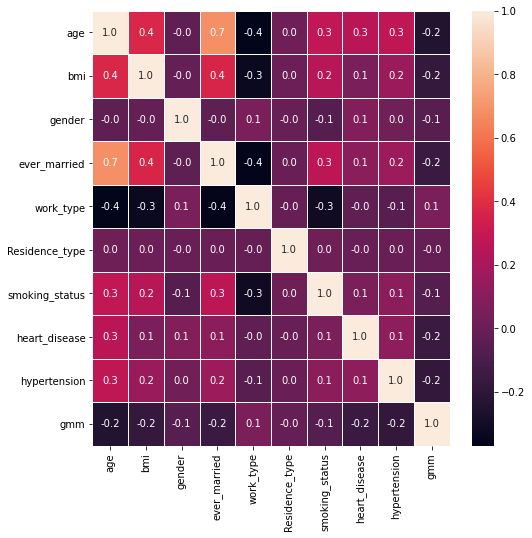

In [15]:
#checking collinearity using heatmap
f,ax = plt.subplots(figsize=(8,8))
sns.heatmap(x_pp.corr(), annot=True, linewidths=.5, fmt= '.1f',ax=ax)

# Random Forest Classification with univariate feature selection

In [16]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score,confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

# Selecting top 4 features
x_train, x_test, y_train, y_test = train_test_split(x_pp, y, test_size=0.3, random_state=43)

select_feature = SelectKBest(chi2, k=4).fit(x_train, y_train)

rec_result = pd.DataFrame({'features':x_train.columns,'score':select_feature.scores_}).sort_values(by=['score'], ascending=False)
rec_result

,features,score
0,age,2357.946170
8,hypertension,76.546730
7,heart_disease,49.804857
1,bmi,21.126633
3,ever_married,13.413383
9,gmm,12.510519
6,smoking_status,7.883178
4,work_type,2.409869
5,Residence_type,0.011193
2,gender,0.002024


In [17]:
x_train

,age,bmi,gender,ever_married,work_type,Residence_type,smoking_status,heart_disease,hypertension,gmm
768,39.0,22.7,0,0,0,1,2,0,0,1
380,40.0,31.7,0,1,2,0,3,0,0,1
1356,62.0,45.5,1,1,3,1,2,0,0,1
4764,30.0,21.1,1,1,2,1,0,0,0,1
2272,14.0,29.7,1,0,3,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...
307,60.0,23.6,0,1,2,0,2,0,0,1
2064,18.0,23.4,0,0,2,0,2,0,0,1
2325,17.0,43.0,0,0,2,0,2,0,0,1
2303,67.0,30.9,0,1,2,1,2,0,1,1


Accuracy is:  0.9440993788819876


<AxesSubplot:>

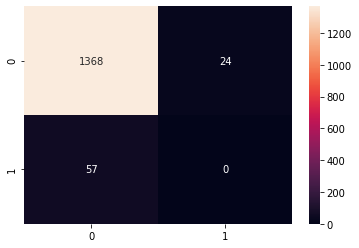

In [18]:
x_train_rfc = select_feature.transform(x_train)
x_test_rfc = select_feature.transform(x_test)
clf_rf = RandomForestClassifier()      
clr_rf = clf_rf.fit(x_train_rfc,y_train)
ac = accuracy_score(y_test,clf_rf.predict(x_test_rfc))
print('Accuracy is: ',ac)
cm = confusion_matrix(y_test,clf_rf.predict(x_test_rfc))
sns.heatmap(cm,annot=True,fmt="d")

In [19]:
x_test_rfc

array([[33. , 32.6,  0. ,  0. ],
       [30. , 24. ,  0. ,  0. ],
       [82. , 32.5,  1. ,  0. ],
       ...,
       [61. , 22.7,  0. ,  0. ],
       [44. , 25. ,  0. ,  0. ],
       [69. , 33.5,  0. ,  1. ]])

In [20]:
clf_rf.predict([[81,31.4,1,0]])

array([0])

In [21]:
import pickle

pickle.dump(clr_rf, open('model.pkl', 'wb'))

References:

[Discussion: When you have bimodal distribution ](http://www.kaggle.com/c/santander-customer-transaction-prediction/discussion/86951)


[Random Forest Classifiers](https://www.kaggle.com/kanncaa1/feature-selection-and-data-visualization)